In [ ]:
import json
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from collections import Counter

DATA_DIR = Path("data")
FILES = sorted(DATA_DIR.glob("dblp-ref-*.json"))

def load_dblp(files):
    rows = []
    for fp in files:
        with fp.open() as f:
            for line in f:
                try:
                    rec = json.loads(line)
                except:
                    continue
                
                title = rec.get("title", "")
                abstract = rec.get("abstract", "")
                venue = rec.get("venue", "")
                authors = rec.get("authors", [])
                
                if not title and not abstract:
                    continue

                rows.append({
                    "title": title,
                    "abstract": abstract,
                    "text": f"{title} {abstract}".strip(),
                    "venue": venue,
                    "authors": authors if isinstance(authors, list) else []
                })

    return pd.DataFrame(rows)

df = load_dblp(FILES)
print("Loaded:", df.shape)

sample_size = 20000
df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)

text_data = df_sample['title'].fillna('')


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(text_data).toarray()
print("TF-IDF feature matrix shape:", X.shape)


TF-IDF feature matrix shape: (20000, 5000)


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
n_samples = X_scaled.shape[0]


In [ ]:
#Purity function
def compute_purity(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    assert y_true.shape[0] == y_pred.shape[0], "y_true and y_pred must be same length"
    n = y_true.shape[0]
    if n == 0:
        return 0.0
    total_majority = 0
    for cluster_label in np.unique(y_pred):
        idx = np.where(y_pred == cluster_label)[0]
        if idx.size == 0:
            continue
        true_counts = np.bincount(y_true[idx].astype(int))
        majority = true_counts.max()
        total_majority += majority
    return total_majority / n


In [ ]:
#SSE function
def compute_sse(X, y_pred):
    X = np.asarray(X)
    y_pred = np.asarray(y_pred)
    n, d = X.shape
    if n == 0:
        return 0.0
    sse = 0.0
    for cluster_label in np.unique(y_pred):
        idx = np.where(y_pred == cluster_label)[0]
        if idx.size == 0:
            continue
        cluster_points = X[idx]
        centroid = cluster_points.mean(axis=0)
        diffs = cluster_points - centroid
        sse += np.sum(np.sum(diffs**2, axis=1))
    return sse / n


In [ ]:
# KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD

vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X = vectorizer.fit_transform(text_data).toarray()

svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

n_samples = X_scaled.shape[0]

ks = [2, 5, 10]
km_results = []

for k in ks:
    sses = []
    sils = []
    for run in range(2):  
        kmeans = MiniBatchKMeans(n_clusters=k, batch_size=1000, n_init=2, random_state=run)
        labels = kmeans.fit_predict(X_scaled)
        
        sse = compute_sse(X_scaled, labels)
        sses.append(sse)
    
        sil = silhouette_score(X_scaled, labels) if k > 1 else np.nan
        sils.append(sil)
    
    km_results.append((k, np.nan, np.mean(sses), np.mean(sils)))

df_km = pd.DataFrame(km_results, columns=['k','Purity','SSE','Silhouette'])
print("\nKMeans (MiniBatch) Experiment Summary:")
print(df_km)



KMeans (MiniBatch) Experiment Summary:
    k  Purity        SSE  Silhouette
0   2     NaN  99.248682    0.092594
1   5     NaN  96.820930    0.053556
2  10     NaN  92.920542    0.078936


In [ ]:
# DBSCAN
eps_values = [0.5, 0.7, 0.9, 1.1, 1.3]
db_results = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5, metric='euclidean').fit(X_scaled)
    labels = db.labels_
    n_clusters = len(set(labels) - {-1})
    n_noise = np.sum(labels == -1)
    mask_core = labels != -1
    if np.sum(mask_core) == 0:
        sse = np.nan
        sil = np.nan
    else:
        sse = compute_sse(X_scaled[mask_core], labels[mask_core])
        sil = silhouette_score(X_scaled[mask_core], labels[mask_core]) if n_clusters > 1 else np.nan
    db_results.append((eps, n_clusters, n_noise, np.nan, sse, sil))

df_db = pd.DataFrame(db_results, columns=['eps','Number of Clusters','Number of Noise','Purity','SSE','Silhouette'])
print("\nDBSCAN Experiment Summary:")
print(df_db)



DBSCAN Experiment Summary:
   eps  Number of Clusters  Number of Noise  Purity       SSE  Silhouette
0  0.5                   5            19773     NaN  0.053654    0.813019
1  0.7                   6            19553     NaN  0.340801    0.331176
2  0.9                  16            19224     NaN  0.647437    0.318028
3  1.1                  34            18815     NaN  0.836511    0.367033
4  1.3                  60            18302     NaN  1.161234    0.349040


In [ ]:
# Agglomerative clustering
thresholds = [10, 25, 50]
agg_results = []

for thresh in thresholds:
    agg = AgglomerativeClustering(n_clusters=None, distance_threshold=thresh, linkage='ward')
    labels = agg.fit_predict(X_scaled)
    n_clusters = len(np.unique(labels))
    sse = compute_sse(X_scaled, labels)
    agg_results.append((thresh, n_clusters, np.nan, sse))

df_agg = pd.DataFrame(agg_results, columns=['Distance Threshold','Number of Clusters','Purity','SSE'])
print("\nHierarchical Clustering Experiment Summary:")
print(df_agg)


Hierarchical Clustering Experiment Summary:
   Distance Threshold  Number of Clusters  Purity        SSE
0                  10                5724     NaN  10.122632
1                  25                 597     NaN  39.231614
2                  50                 121     NaN  50.681031


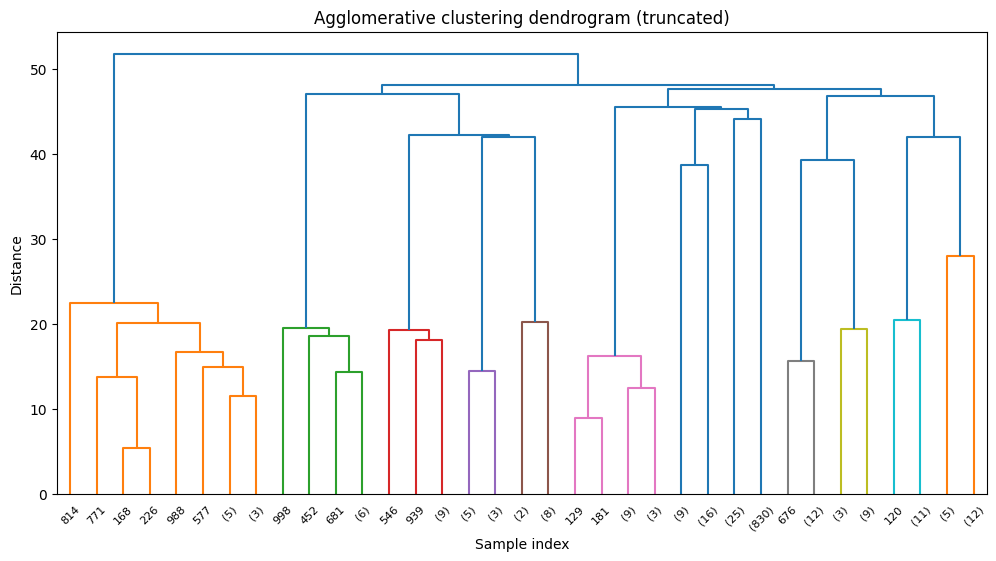

In [ ]:
# Dendrogram visualization (sampled even further to 1000 for readability)
sample_idx = np.random.choice(n_samples, min(1000, n_samples), replace=False)
Z = linkage(X_scaled[sample_idx], method='ward')
plt.figure(figsize=(12,6))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Agglomerative clustering dendrogram (truncated)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

Top words per KMeans cluster:
Cluster 0: agents, affective, adaptive, age, algebra, action, analytical, air, agent, adoption
Cluster 1: academic, active, access, acquisition, 10, affect, abstract, actions, ad, actuator
Cluster 2: 2010, agent, accelerating, abstraction, accuracy, algorithm, 802, actuator, annealing, agreement
Cluster 3: algorithms, amplifier, applications, ambient, allocation, algorithmic, ai, applied, advanced, 15
Cluster 4: analyses, adaptive, analyzing, adjustment, approximations, ai, activities, anti, algorithm, affective
Cluster 5: affect, affine, algebra, ai, agile, activity, advances, affective, adapting, adjustment
Cluster 6: 15, 10, 3d, analytical, accelerated, approximation, antenna, algebra, additive, actions
Cluster 7: analysing, analog, analytical, annotation, analysis, analyses, anonymous, algorithmic, anti, applying
Cluster 8: air, action, affective, advanced, active, algebras, aided, age, 3d, analysis
Cluster 9: affine, advances, acquisition, age, agreem

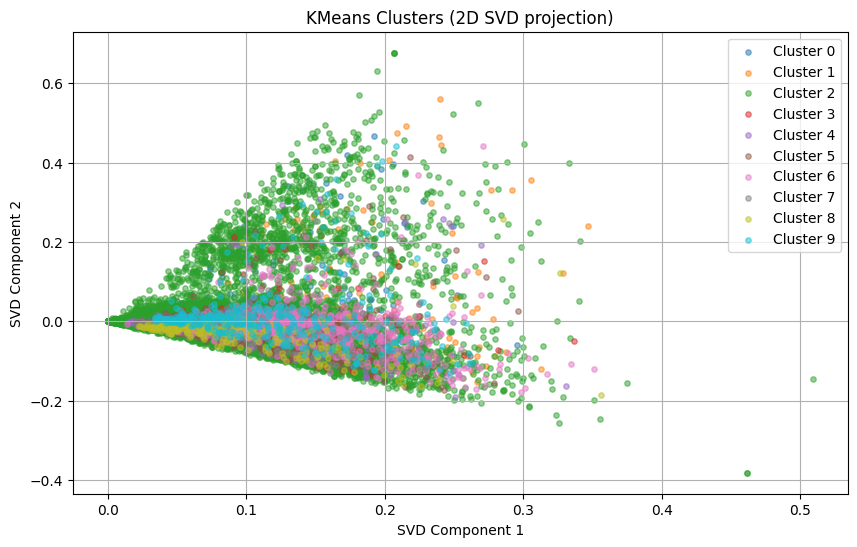

In [ ]:
# Top words per cluster
feature_names = vectorizer.get_feature_names_out()
n_top_words = 10

print("Top words per KMeans cluster:")
for cluster_id in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[cluster_id]
    top_indices = centroid.argsort()[-n_top_words:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    print(f"Cluster {cluster_id}: {', '.join(top_words)}")

# 2D visualization of clusters
X_2d = X_reduced[:, :2]

plt.figure(figsize=(10, 6))
for cluster_id in range(kmeans.n_clusters):
    idx = np.where(kmeans.labels_ == cluster_id)
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=f'Cluster {cluster_id}', alpha=0.5, s=15)

plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("KMeans Clusters (2D SVD projection)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Author clustering
from collections import defaultdict
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

MIN_AUTHOR_PAPERS = 3        
AUTHOR_K = 10                
SVD_COMPONENTS = 100   
RANDOM_STATE = 42

if 'X_tfidf' not in globals() or 'feature_names' not in globals():
    print("Computing TF-IDF (max_features=5000)...")
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2), min_df=2)
    X_tfidf = vectorizer.fit_transform(df['text'])
    feature_names = vectorizer.get_feature_names_out()

author_text = defaultdict(list)
for i, authors in enumerate(df['authors']):
    if not isinstance(authors, list): 
        continue
    for a in authors:
        if a:
            author_text[a].append(df.iloc[i]['text'])

author_items = {a: " ".join(texts) for a, texts in author_text.items() if len(texts) >= MIN_AUTHOR_PAPERS}
author_df = pd.DataFrame({'author': list(author_items.keys()), 'text': list(author_items.values())})
print("Authors considered:", author_df.shape[0])

Xa_tfidf = vectorizer.transform(author_df['text'])

from sklearn.decomposition import TruncatedSVD
if SVD_COMPONENTS:
    svd = TruncatedSVD(n_components=SVD_COMPONENTS, random_state=RANDOM_STATE)
    Xa_reduced = svd.fit_transform(Xa_tfidf)
else:
    Xa_reduced = Xa_tfidf.toarray()

scaler = StandardScaler()
Xa_std = scaler.fit_transform(Xa_reduced)

mbk = MiniBatchKMeans(n_clusters=AUTHOR_K, random_state=RANDOM_STATE, batch_size=1024, n_init=5)
author_labels = mbk.fit_predict(Xa_reduced)

author_df['cluster'] = author_labels

sil = silhouette_score(Xa_reduced, author_labels) if AUTHOR_K > 1 and Xa_reduced.shape[0] > AUTHOR_K else float('nan')
print(f"Author clustering done: authors={Xa_reduced.shape[0]}, k={AUTHOR_K}, silhouette={sil:.4f}")

def top_terms_for_indices_sparse(X_sparse, indices, feature_names, top_n=12):
    if len(indices) == 0:
        return []
    sub = X_sparse[indices]
    mean_tfidf = np.asarray(sub.mean(axis=0)).ravel()
    top_idx = mean_tfidf.argsort()[-top_n:][::-1]
    return [feature_names[i] for i in top_idx if mean_tfidf[i] > 0][:top_n]

print("\nTop terms per author cluster (sample):")
for c in sorted(author_df['cluster'].unique()):
    idxs = author_df[author_df['cluster'] == c].index.values
    top_terms = top_terms_for_indices_sparse(Xa_tfidf, idxs, feature_names, top_n=10)
    print(f"Cluster {c}: {top_terms[:10]}")


Authors considered: 1936
Author clustering done: authors=1936, k=10, silhouette=0.0326

Top terms per author cluster (sample):
Cluster 0: ['business', 'process', 'information', 'service', 'cloud', 'systems', 'business process', 'management', 'services', 'enterprise']
Cluster 1: ['logic', 'reasoning', 'programming', 'knowledge', 'logic programming', 'logics', 'based', 'systems', 'theories', 'belief']
Cluster 2: ['based', 'algorithm', 'data', 'using', 'method', 'problem', 'image', 'paper', 'model', 'approach']
Cluster 3: ['speech', 'recognition', 'speech recognition', 'speaker', 'acoustic', 'based', 'language', 'spoken', 'using', 'synthesis']
Cluster 4: ['languages', 'model', 'abstract', 'extended', 'models', 'extended abstract', 'object', 'systems', 'formal', 'software']
Cluster 5: ['security', 'information', 'systems', 'information security', 'management', 'resource', 'key', 'secure', 'level', 'resource management']
Cluster 6: ['search', 'medical', 'retrieval', 'information', 'semantic